In [288]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
path = "../data_cleaned/"
TRAIN_PERC = 0.95
SIZE = 70

dataset_stocks = {}

for file in os.listdir(path):
    if (file.endswith(".csv")):
        temp = pd.read_csv(os.path.join(path, file))
        temp = temp.set_index(pd.to_datetime(temp[file[:-4]]))
        dataset_stocks[file[:-4]] = temp.drop([file[:-4]], axis = 1)

In [289]:
dataset_stocks

{'AMZN':                Open      High     Low   Close    Volume  10 day average  \
 AMZN                                                                      
 2010-06-30  108.580  112.6800  108.11  109.26   9740933             NaN   
 2010-07-01  108.900  111.6900  106.70  110.96   8530343             NaN   
 2010-07-02  110.920  111.2900  108.56  109.14   4477302             NaN   
 2010-07-06  110.650  112.5300  109.00  110.06   5219407             NaN   
 2010-07-07  109.840  113.6300  109.81  113.43   4944960             NaN   
 ...             ...       ...     ...     ...       ...             ...   
 2024-04-08  186.900  187.2900  184.81  185.19  39221281         181.255   
 2024-04-09  187.240  187.3400  184.20  185.67  36546953         181.851   
 2024-04-10  182.765  186.2699  182.67  185.95  35879152         182.616   
 2024-04-11  186.740  189.7700  185.51  189.05  40020738         183.538   
 2024-04-12  187.720  188.3800  185.08  186.13  38608848         184.113   
 
  

In [185]:
from sklearn.preprocessing import MinMaxScaler

def generate_train_data(stock, train_perc = 0.95, size = 60, __ = False):
    data = stock.filter(["Close"]).values
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(data)

    if __:
        return scaled_data

    train_size = int(np.ceil(len(data) * train_perc))
    train_data = scaled_data[0:train_size]

    tmp = list(map(lambda x: x[0], train_data))

    x_train=[]
    y_train=[]

    for i in range(size, len(train_data)):
        x_train.append(tmp[i-60:i])
        y_train.append(tmp[i])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    return x_train, y_train

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

def build_model(train_x, train_y, batch_size=1, epochs=1):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    
    model.compile(optimizer="adam", loss="mean_squared_error")
    model.fit(x_train, y_train, batch_size=1, epochs=1)
    return model

In [201]:
def rmse(df, pred="pred", test="Close"):
    pred = df[pred]
    test = df[test]

    rmse = np.sqrt(np.mean(((pred - test) ** 2)))
    return rmse

In [202]:
def eval_model(model, stock, train_perc=0.95, size=60):
    
    data = stock.filter(["Close"])
    train_size = int(np.ceil(len(data.values) * train_perc))
    
    scaled_data = generate_train_data(stock, __=True)
    test = scaled_data[train_size - size: , :]
    x_test = []
    y_test = data.values[train_size: , :]
    for i in range(60, len(test)):
        x_test.append(test[i-60:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    pred = scaler.inverse_transform(model.predict(x_test))

    return pred
    

In [231]:
def return_res(stock, pred, train_perc=0.95, plot=False):
    data = stock.filter(["Close"])
    train_size = int(np.ceil(len(data.values) * train_perc))
    
    train = data[:train_size]
    validation = data[train_size:]
    validation["pred"] = pred
    if plot:
        plt.figure(figsize=(16,6))
        plt.plot(train["Close"])
        plt.plot(validation[["Close", "pred"]])
        plt.legend(["Train", "Actual", "Prediction"], loc="lower right")
        plt.axis([pd.to_datetime("2022-05"), pd.to_datetime("2024-05"), 150, 210])
        plt.axis([pd.to_datetime("2024-03"), pd.to_datetime("2024-07"), 165, 180])
        plt.show()
    return validation

In [309]:
df = dataset_stocks["AAPL"]
df

,Open,High,Low,Close,Volume,10 day average,20 day average,50 day average,Daily Return
AAPL,,,,,,,,,
2010-06-30,7.74275,7.78046,7.54095,7.58611,8.741840e+08,NaN,NaN,NaN,NaN
2010-07-01,7.66393,7.68466,7.33563,7.49474,1.210385e+09,NaN,NaN,NaN,-0.012044
2010-07-02,7.56051,7.56761,7.33493,7.44742,8.216020e+08,NaN,NaN,NaN,-0.006314
2010-07-06,7.44742,7.62501,7.42500,7.49938,7.276023e+08,NaN,NaN,NaN,0.006977
2010-07-07,7.55853,7.80398,7.53236,7.80051,7.729481e+08,NaN,NaN,NaN,0.040154
...,...,...,...,...,...,...,...,...,...
2024-04-08,168.60600,168.77600,167.81800,168.02800,3.751965e+07,169.6453,171.34750,177.93256,-0.006657
2024-04-09,168.27600,169.65400,167.92800,169.24400,4.255799e+07,169.5275,171.19385,177.48358,0.007237
2024-04-10,168.37600,168.66600,166.69100,167.35900,4.983437e+07,169.3350,170.92205,177.01064,-0.011138


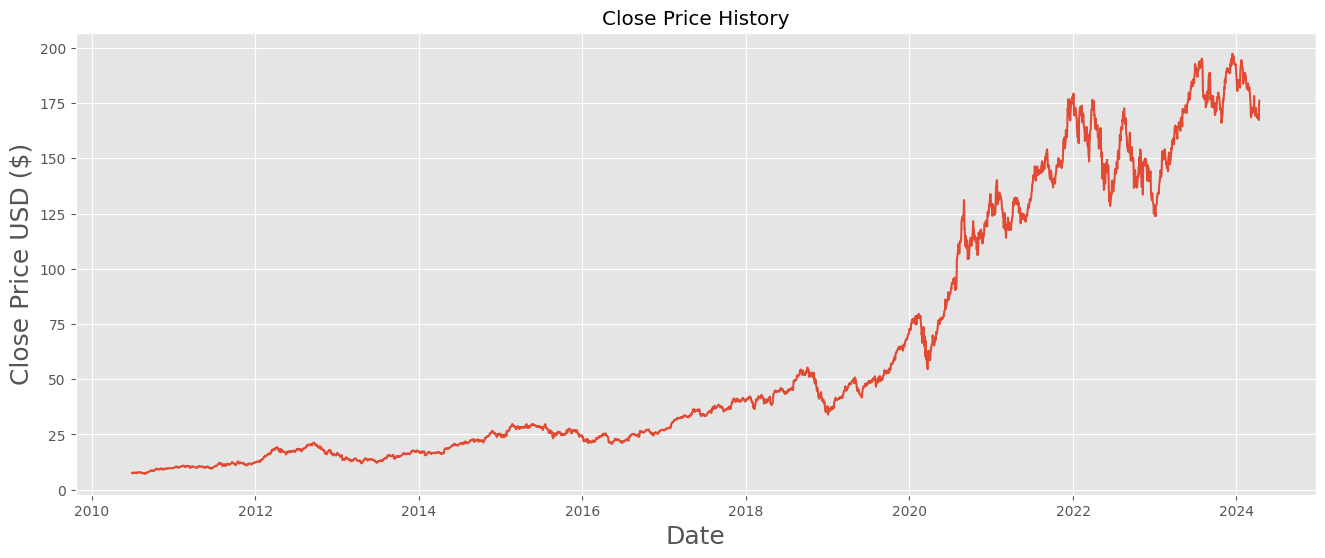

In [310]:
def plot_stock(stock):
    plt.figure(figsize=(16,6))
    plt.title('Close Price History')
    plt.plot(stock['Close'])
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.show()


In [320]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * TRAIN_PERC ))

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00184272],
       [0.00136215],
       [0.00111326],
       ...,
       [0.84219432],
       [0.8802848 ],
       [0.88820586]])

In [312]:
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

for i in range(SIZE, len(train_data)):
    x_train.append(train_data[i-SIZE:i, 0])
    y_train.append(train_data[i, 0])
    if i<= SIZE+1:
        print(x_train)
        print(y_train)
        print()
        
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([1.84272302e-03, 1.36214759e-03, 1.11326033e-03, 1.38655243e-03,
       2.97039483e-03, 2.88576685e-03, 3.12729058e-03, 2.75853559e-03,
       1.88885027e-03, 2.03485852e-03, 1.82804856e-03, 1.58605146e-03,
       8.98771259e-04, 1.90447147e-03, 2.26754603e-03, 3.02867190e-03,
       3.17825672e-03, 3.07180114e-03, 3.83792369e-03, 3.33662518e-03,
       2.88934342e-03, 2.75012013e-03, 3.48016139e-03, 3.49557221e-03,
       3.65562376e-03, 3.45554617e-03, 3.20208299e-03, 3.46443500e-03,
       3.09352355e-03, 1.62812876e-03, 1.88569447e-03, 1.45766308e-03,
       1.22802618e-03, 1.91330771e-03, 2.08787593e-03, 1.58189632e-03,
       1.54134432e-03, 9.36746027e-04, 0.00000000e+00, 4.73264500e-04,
       5.98023713e-05, 2.74291439e-04, 4.11463457e-04, 5.05927009e-04,
       1.65253360e-03, 1.94397154e-03, 2.98864586e-03, 2.84263761e-03,
       3.64726089e-03, 3.67124496e-03, 3.72526170e-03, 4.30240455e-03,
       4.46755798e-03, 4.80722703e-03, 5.81461033e-03, 5.62400014e-03,
     

In [318]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=10, epochs=10)

/Users/kaslisk/.pyenv/versions/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 0.0027
Epoch 2/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 3.5698e-04
Epoch 3/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 3.2008e-04
Epoch 4/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 2.1697e-04
Epoch 5/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 2.3399e-04
Epoch 6/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 1.9667e-04
Epoch 7/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 1.8723e-04
Epoch 8/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.8633e-04
Epoch 9/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1.4596e-04
Epoch 10/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 1.7260e-04


In [319]:
test_data = scaled_data[training_data_len - SIZE: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(SIZE, len(test_data)):
    x_test.append(test_data[i-SIZE:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


6.00703122459917

In [315]:
mean = np.mean(y_test)
mean

180.61583236994218

In [316]:
rmse/mean

0.03651167990422002

/var/folders/fv/7y8nb909551c28ks_2lfw0tc0000gn/T/ipykernel_20640/2769429276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


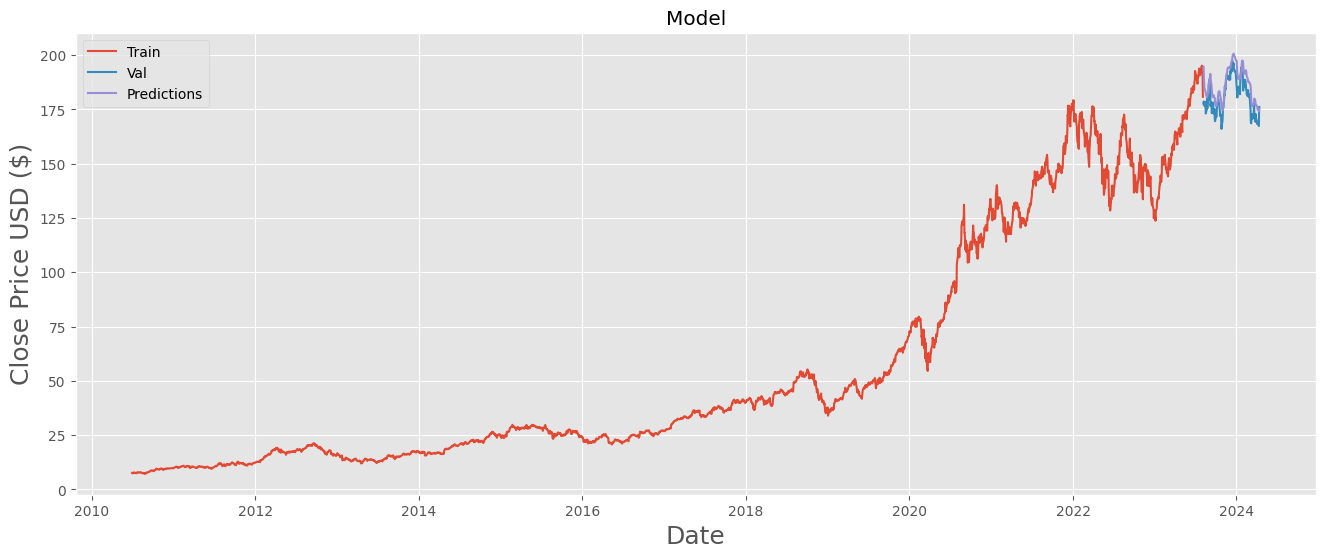

In [317]:

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
plt.show()